<div width=50% style="display: block; margin: auto">
    <img src="figures/ucl-logo.svg" width=100%>
</div>

### [UCL-ELEC0136 Data Acquisition and Processing Systems 2024]()
University College London
# Lab 4: Data Processing #2 





### Objectives
The data processing 2 lab focuses on Exploratory Data Analysis (EDA) techniques and addressing data imbalance through fairness postprocessing methods. In particular, we will
* Learn how to plot and interpret insights from plots
* Briefly cover the steps of (1) data transformation, (2) generating data splits, (3) selecting baseline models and building a classifier
* Learn how to produce and evaluate the models for performance and fairness
* Learn how to leverage fairness metrics for threshold optimization.


### Outline
0. Setup
1. Data Processing
2. Train Baselines and a Classifier (Offline)
3. Evaluate and Audit for Fairness the Baselines and the Classifier
4. Postprocessing Techniques for Fairness

<hr width=70% style="float: left">

### 0. Setup

#### 0.1 Prerequisites
This lab uses the following packages:

* `folktables`: datasets derived from the American Community Survey (ACS)  Public Use Microdata Sample (PUMS) files which are managed by the US Census Bureau <!-- - more info [here](https://github.com/socialfoundations/folktables)) -->
* `scikit-learn`: toolkit for predictive data analysis
* `pandas`: data analysis and manipulation toolkit
* `matplotlib`: statistical visualization library
* `seaborn`: statistical visualization library
* `fairlearn`: toolkit for assessing and mitigating an ML system's biases

<div class="alert alert-block alert-danger">
<h4>👨🏾‍💻👨🏿‍💻 TASK 1: Install Prerequisites</h4>

Use the `requirements.txt` file for installing the libraries discussed above.
</div>

Let's import the following libraries

In [31]:
# Libraries for data analysis and manipulation
import numpy as np
import pandas as pd

# Libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#### 0.2 Data Acquisition

`folktables` offers predefined predictive tasks and the ability to specify the ML problem you want to address. While we won't delve into the thechnical implementation here, the curious minds can explore the details in the `utils/dataset.py` file.

In this lab, we specifically focus on **employment status classification** based on 15 input features such as gender, race, marital status, and age.

In [32]:
from utils.dataset import ACSDataset

# Selected target - Employment status record
target_task='ESR'

# Sensitive group
sensitive_group= 'RAC1P'

# Pick a state to download data from available_states list.
state_list=['CA']

# Pick data duration. Available options: ["1-Year", "5-Year"].
duration='1-Year'

# Pick data year. Available options: ["2015", "2016", "2017", "2018"].
year='2018'

# Pick data granularity. Available options: ["person", "household"].
granularity= 'person'

ACSProblem=ACSDataset(target_task,sensitive_group,state_list,duration,year,granularity)


In [33]:
dataset_df=ACSProblem.acquire_dataset()

### 1. Data Processing  

#### 1.1 (Initial) Data Exploration & Data Cleaning
Next we will investigate, analyze and summarize the characteristics of the acquired dataset. This is valuable for

1. spotting errors within the dataset;
2. grasping data patterns and relationships across variables; and
3. identifying outliers or irregular behaviors,

and dealing with these issues. 

First, let's take an initial look at our data:

In [34]:
# Get the dataset shape (rows,columns)
print('Dataset shape (rows,columns) is ', dataset_df.shape)
print('\n')

# Get an overview of the dataset by printing the first 10 rows
print('Dataset Overview:')
dataset_df.head(10)

Dataset shape (rows,columns) is  (195665, 17)


Dataset Overview:


,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,30.0,14.0,1.0,16.0,2.0,0.0,1.0,3.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,8.0,0.0
1,21.0,16.0,5.0,17.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0
2,65.0,22.0,5.0,17.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0
3,33.0,14.0,3.0,16.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0
4,18.0,19.0,5.0,17.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0
5,17.0,15.0,5.0,16.0,2.0,0.0,1.0,3.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,9.0,0.0
6,27.0,21.0,5.0,17.0,2.0,0.0,1.0,1.0,1.0,3.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0
7,19.0,18.0,5.0,17.0,2.0,0.0,1.0,3.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,0.0
8,27.0,19.0,5.0,17.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0
9,19.0,16.0,5.0,17.0,2.0,0.0,1.0,3.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0


In [35]:
# Print the index dtype and columns, non-null values and memory usage
print('Information about the dataset:')
dataset_df.info()

Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195665 entries, 0 to 195664
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AGEP      195665 non-null  float64
 1   SCHL      195665 non-null  float64
 2   MAR       195665 non-null  float64
 3   RELP      195665 non-null  float64
 4   DIS       195665 non-null  float64
 5   ESP       195665 non-null  float64
 6   CIT       195665 non-null  float64
 7   MIG       195665 non-null  float64
 8   MIL       195665 non-null  float64
 9   ANC       195665 non-null  float64
 10  NATIVITY  195665 non-null  float64
 11  DEAR      195665 non-null  float64
 12  DEYE      195665 non-null  float64
 13  DREM      195665 non-null  float64
 14  SEX       195665 non-null  float64
 15  RAC1P     195665 non-null  float64
 16  ESR       195665 non-null  float64
dtypes: float64(17)
memory usage: 25.4 MB


<div class="alert alert-block alert-danger">
<h4>👩🏼‍💻👩🏽‍💻 Task 1.1: Deal with erroneous data types</h4>

Erroneous data types occur when the format or the categorization of the data type does not align with the intended or expected type for a given attribute or variable. 
The basic overview of the data above shows that evey column is a numerical.

Fix this issue as follows:

* Create a function `cast_features(categorical_features: list[str], numerical_features: list[str], data:pd.DataFrame)` that fixes the erroneous datatypes of the dataframe
* The function should return a pandas dataframe containing the updated data
  
</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
<b>💎 Tips</b> 

* The target should not be part of the input features
* Use `ACSProblem.categorical_features` and `ACSProblem.numerical_features` to find the categorical and numerical features of this dataset.
</div>




In [36]:
def cast_features(categorical_features: list[str], numerical_features: list[str], data:pd.DataFrame) -> pd.DataFrame:
    """
    Cast features to the correct data type.

    Args:
        categorical_features (List[str]): list of categorical feature names
        numerical_features (List[str]): list of numerical feature names
        data (pd.DataFrame): raw dataframe with unprocessed data
    Returns:
        (pd.DataFrame): a dataframe with the casted features data
    """
    # Add your code here:

    # Cast categorical features to `object`
    data[categorical_features] = data[categorical_features].astype("object")

    # Cast numerical features to `int`
    data[numerical_features] = data[numerical_features].astype("int")

    return data

# Cast feature types
df=cast_features(ACSProblem.categorical_features, ACSProblem.numerical_features, dataset_df)

# Confirm that the correctness of the datatypes
print('Information about the dataset:')
df.info()

Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195665 entries, 0 to 195664
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AGEP      195665 non-null  int64  
 1   SCHL      195665 non-null  object 
 2   MAR       195665 non-null  object 
 3   RELP      195665 non-null  object 
 4   DIS       195665 non-null  object 
 5   ESP       195665 non-null  object 
 6   CIT       195665 non-null  object 
 7   MIG       195665 non-null  object 
 8   MIL       195665 non-null  object 
 9   ANC       195665 non-null  object 
 10  NATIVITY  195665 non-null  object 
 11  DEAR      195665 non-null  object 
 12  DEYE      195665 non-null  object 
 13  DREM      195665 non-null  object 
 14  SEX       195665 non-null  object 
 15  RAC1P     195665 non-null  object 
 16  ESR       195665 non-null  float64
dtypes: float64(1), int64(1), object(15)
memory usage: 25.4+ MB


Now that we have fixed the erroneous data types, let's check for missing values! We will start by identyifying the features with missing values and the quantity of these missing values in our dataset.

In [37]:
# Print the missing values per column
df.isna().sum()

AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
ESR         0
dtype: int64

Since our dataset has no missing values, let's move on to generate and review the descriptive statistics of the features and the target. These will help us understand the distribution of both features and the target. Additionally, they will help us determine the most suitable visualization method for each column in the dataset.

In [38]:
# Generate descriptive statistics about your dataset
print('Descriptive statistics for dataset:')
df.describe(include='all')

Descriptive statistics for dataset:


,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
count,195665.000000,195665.0,195665.0,195665.0,195665.0,195665.0,195665.0,195665.0,195665.0,195665.0,195665.0,195665.0,195665.0,195665.0,195665.0,195665.0,195665.000000
unique,NaN,24.0,5.0,18.0,2.0,9.0,5.0,3.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,9.0,NaN
top,NaN,21.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,NaN
freq,NaN,46526.0,102442.0,90761.0,185067.0,194729.0,131618.0,168406.0,185400.0,120263.0,134551.0,192613.0,193466.0,192540.0,103311.0,121006.0,NaN
mean,42.734914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.880449
std,14.884622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.324437
min,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


#### 1.2 Exploratory Data Analysis: Visualisations


**1. Target distribution visualization**

Let's analyze the distribution of samples acfoss each target label. Since our target task (i.e., Employment Status Record - `ESR`) is categorical, an effective method to visualize the target labels is through bar plots.

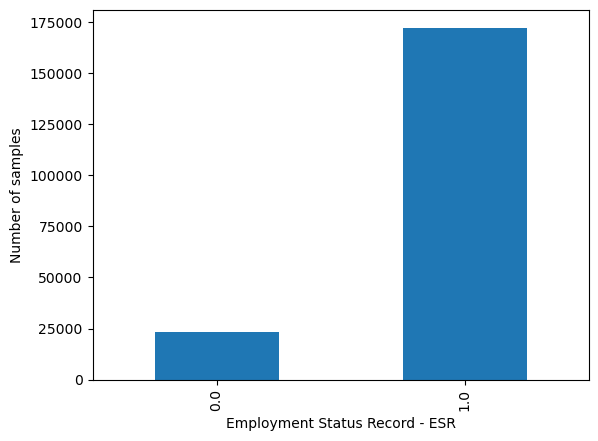

In [39]:

# Create a bar plot to visualize the targets
df[ACSProblem.target_task].value_counts().sort_values().plot(kind='bar')

# Add axes labels
plt.ylabel('Number of samples')
plt.xlabel('Employment Status Record - ESR')

# Show Figure
plt.show()

<div class="alert alert-block alert-danger">
<b> Q: What insights can you derive from the bar plot of the target? </b>
</div>

In [40]:
# Add your answer here:

# We notice that our dataset is heavily imbalanced with the majority class being the employed class (label=1) 
# and the minority class representing the unemployed class (label=0). The minority class comprises roughly 12% 
# of the dataset. We need more insights about the classes that belong to each sensitive group membership

**2. Target and sensitive group distribution visualization**

Now, let's see the proportion of the sensitive group (i.e., Race - `RAC1P`) per target label. For simplicity we include the races from the [original paper](https://arxiv.org/abs/2108.04884) here:

* 1: White alone
* 2: Black or African American alone
* 3: American Indian alone
* 4: Alaska Native alone
* 5: American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races
* 6: Asian alone
* 7: Native Hawaiian and Other Pacific Islander alone
* 8: Some Other Race alone
* 9: Two or More Races

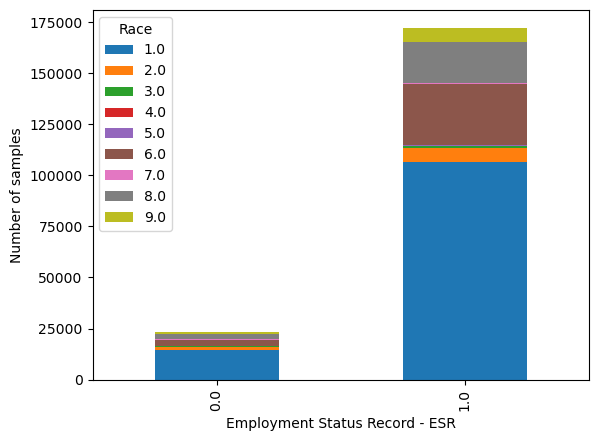

In [41]:
# Grouping based on target and sensitive group and plot
df.groupby([ACSProblem.target_task, ACSProblem.sensitive_group])[ACSProblem.sensitive_group].count().unstack().plot(
    kind="bar", stacked=True)

# Add legend
plt.legend(title='Race')

# Add axes labels
plt.ylabel('Number of samples')
plt.xlabel('Employment Status Record - ESR')

# Show Figure
plt.show()

<div class="alert alert-block alert-danger">
<b> Q: What insights can you derive from the bar plot? </b>
</div>

In [42]:
# Add your answer here:
# We notice that that the distribution of sensitive groups across each target label is relatively similar.
# Additionally, within both the majority and minority target classes, the White race (label=1.0) stands out as the dominant sensitive group, 
# representing the most significant portion of the data samples.
# Finally, we observe that particular sensitive group labels (e.g., 4.0: Alaska Native, 5.0: American Indian and Alaska Native).

<div class="alert alert-block alert-danger">
<h4>👩🏾‍💻👨🏻‍💻 Task 2.1: Find an appropriate visualization for the sensitive groups x targets </h4>

The previous plot allows to investigate a general trend of the sensitive group allocation on each class, but it does not allow to understand what the exact amount of the underrepresented sensitive groups.

* Decide an appropriate plot that allows to effectively display the proportion of each target class per sensitive group. 
* Create a function `sensitive_group_plot(data:pd.DataFrame, sensitive: str, target: str)` that generates the plot. 
* The function must both the `Figure` and the `Axis` objects.
  
</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

* The folowing plot includes the Race (i.e., `RAC1P`) memberships on x-axis, the amount of the samples with this membership on y-axis and the target category using colors.

* This is **not a good visualization because some groups (e.g., group 4 and 5) are not displayed efficiently** (akin to the one above).
</div>


/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 9.444444444444438, 'Race')

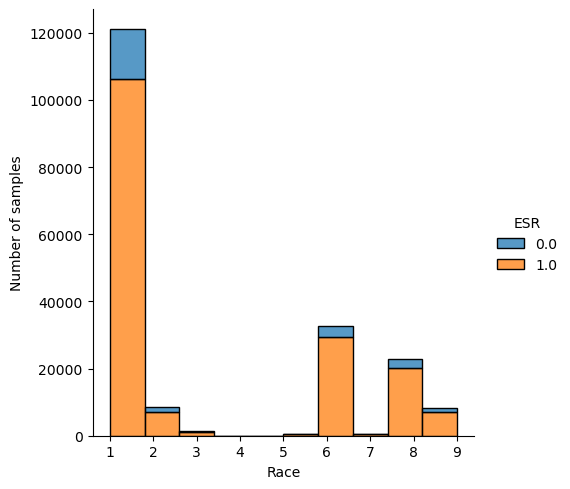

In [43]:
# The following example is a bad visualisation!!!
# Plot a histogram with stacking bars
sns.displot(
    df,
    x=sensitive_group,
    hue=ACSProblem.target_task, 
    kind="hist",
    stat="count",
    bins=10,
    multiple="stack",
)

# Add axes labels
plt.ylabel('Number of samples')
plt.xlabel('Race')


<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
<b>💎 Tip</b>
 
* Use `ACSProblem.race_labels`, `ACSProblem.sensitive_group` and `ACSProblem.target_task` to find the race labels dictionary, the sensitive group and the target name column, respectively.
</div>


(<Figure size 2000x3000 with 9 Axes>,
 <Axes: title={'center': 'Alaska Native'}, ylabel='Number of samples'>)

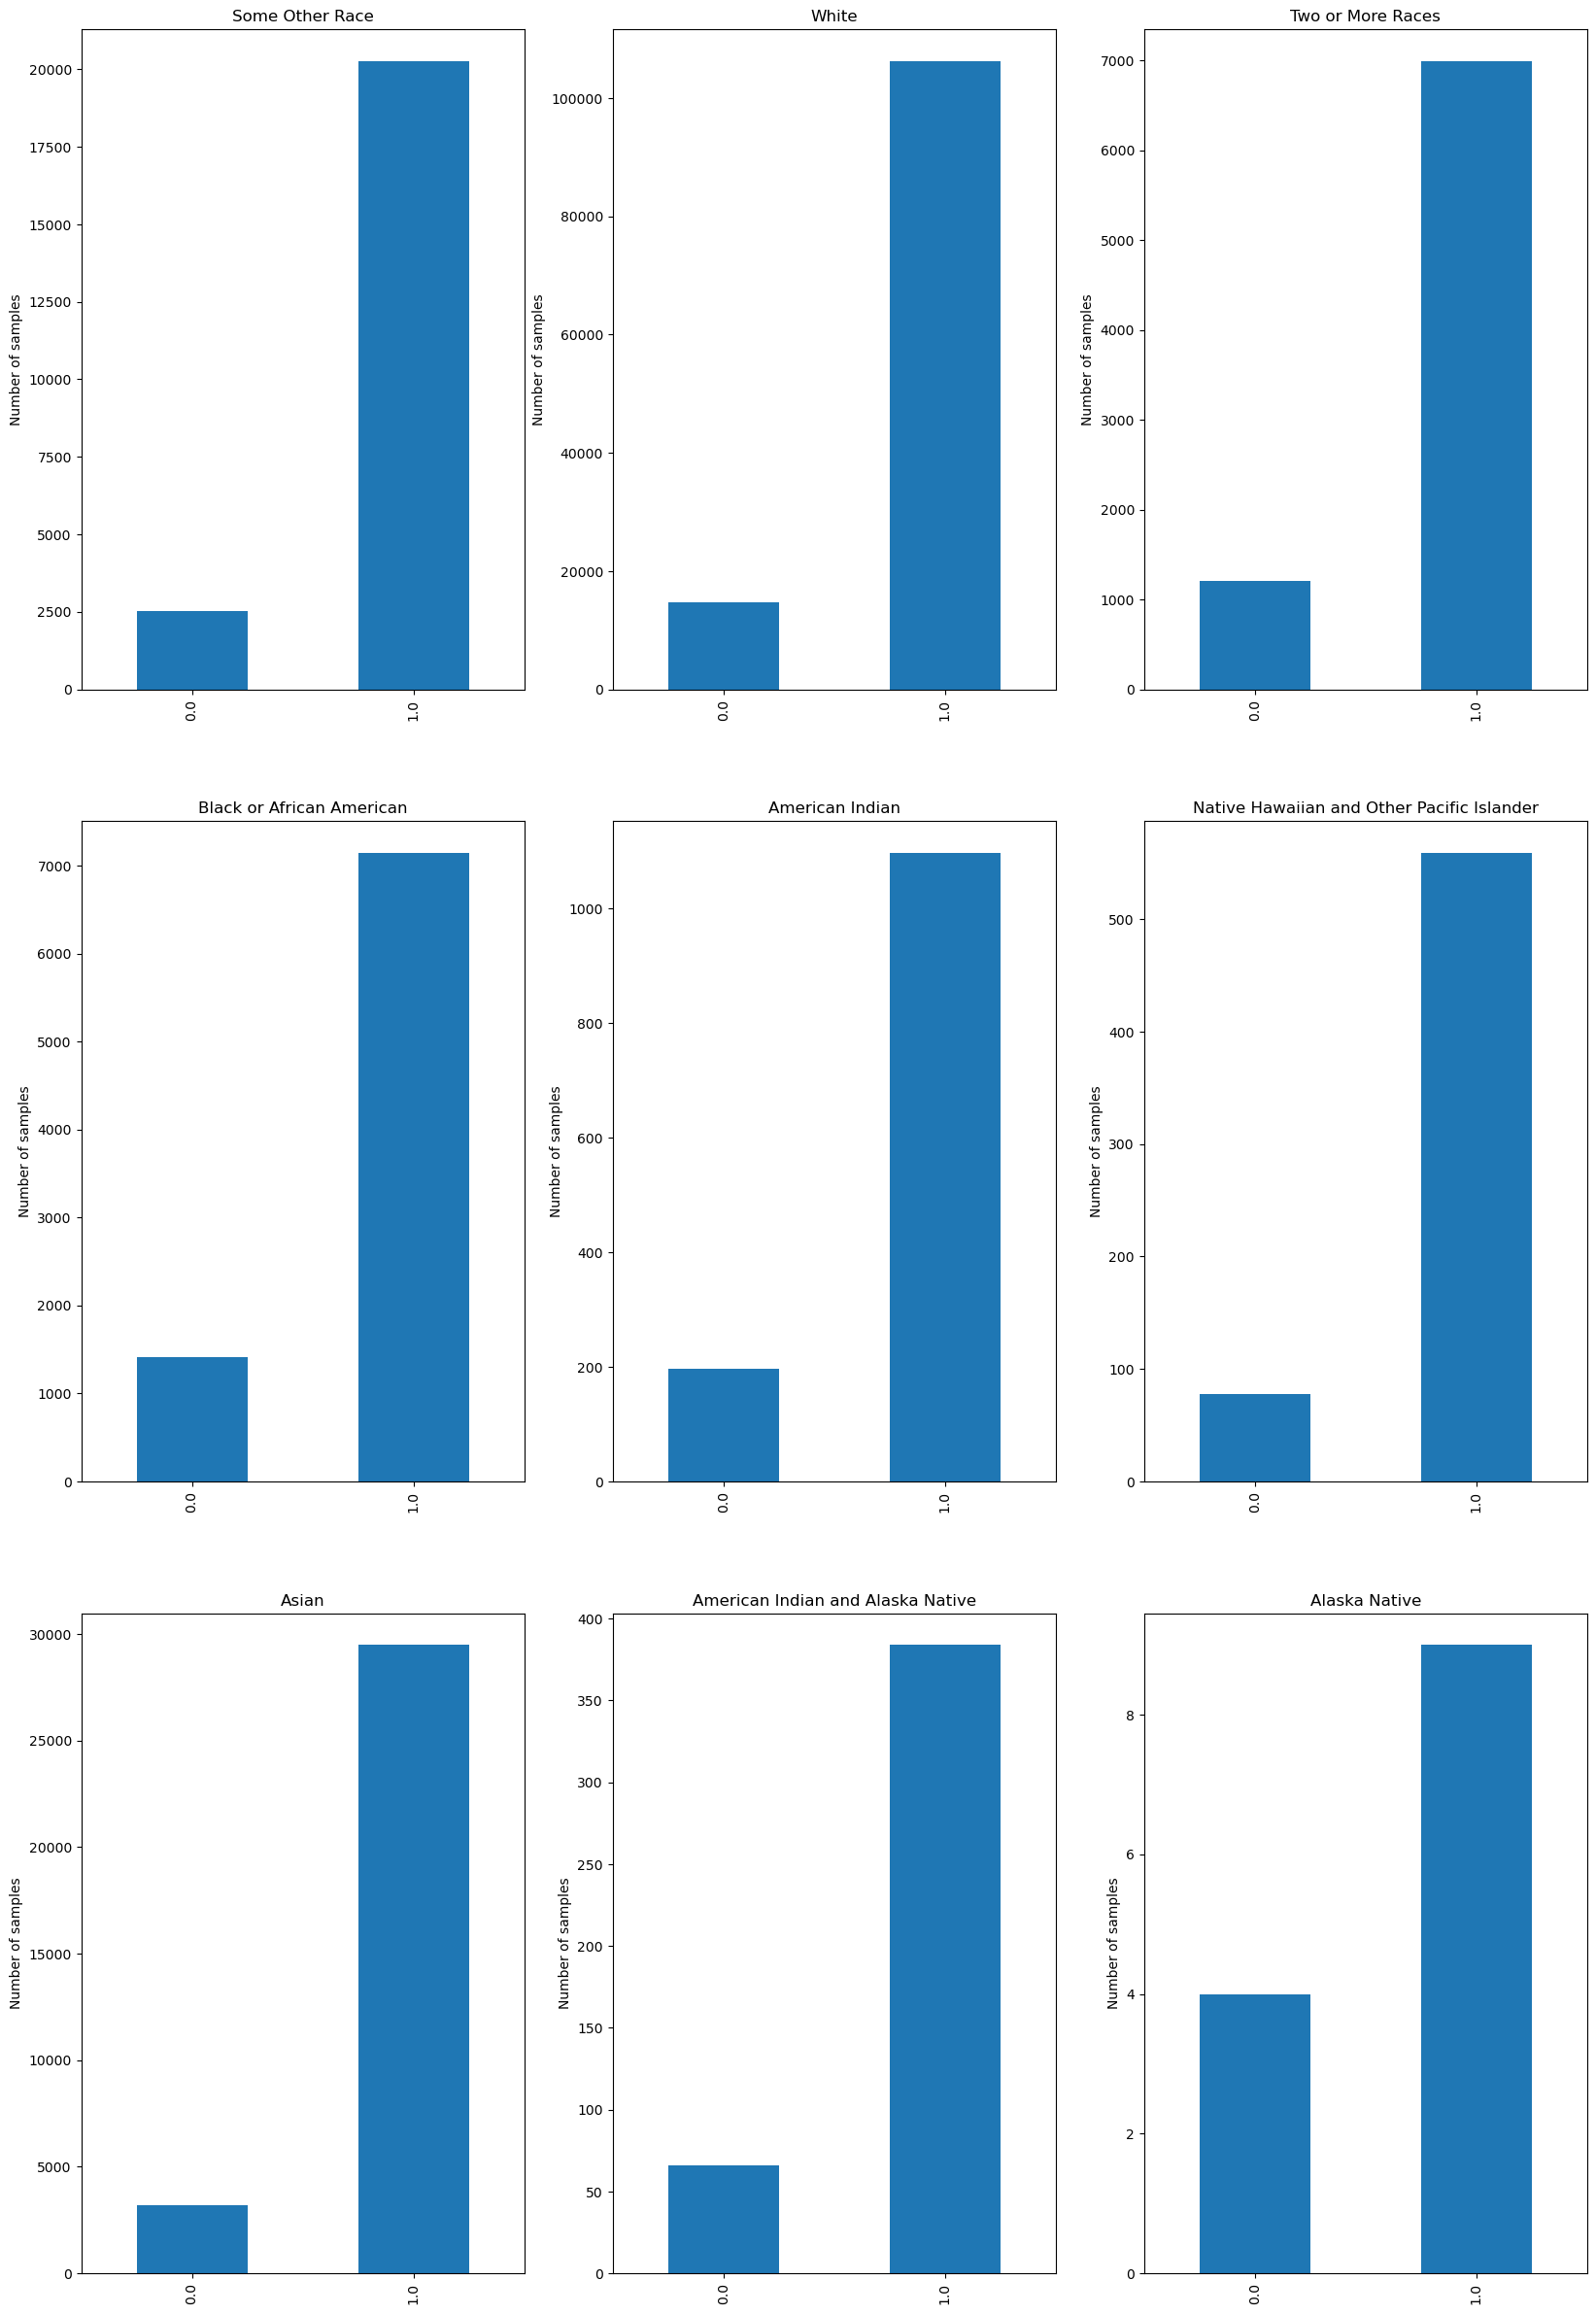

In [44]:
def sensitive_group_plot(data:pd.DataFrame, race_labels : list[str], sensitive: str, target: str) -> (plt.Figure, plt.Axes):
    """
    Creates a line plot for each list of data in the given list of data, title and labels.

    Args:
        data (pd.DataFrame): dataframe including all the avaible data
        race_labels (list[str]): the list of races available in the dataset
        sensitive (str): the column name of the sensitive attribute
        target (str): the column name of the target task
        
    Returns:
        (plt.Figure, plt.Axes): matplotlib figure and axes objects
    """
    
    # Add your code here:

    # Create an array with the sensitive group memberships
    sens_groups=data[sensitive].unique()


    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 30))
    for i, ax in zip(sens_groups, axs.ravel()):
        data[data[sensitive]==i][target].value_counts().sort_values().plot.bar(ax=ax)
        # Set the x-label as title
        ax.set_title(race_labels[i])
        ax.set_xlabel('')
        # Set the y-label
        ax.set_ylabel('Number of samples')

    return (fig, ax)


sensitive_group_plot(df, ACSProblem.race_labels, ACSProblem.sensitive_group, ACSProblem.target_task)
    

<div class="alert alert-block alert-warning">
<h4>👨🏽‍💻👩🏻‍💻 [Optional] TASK 2.2: Input Features Visualisations</h4>

* Create a function `histograms(data:pd.DataFrame, categorical_features: list[str])` that will plot a histogram for each of the features in the categorical features of the dataset 
* The function must return both the `Figure` and the `Axis` objects
</div>

(<Figure size 2000x3000 with 15 Axes>,
 <Axes: title={'center': 'Race'}, ylabel='Number of samples'>)

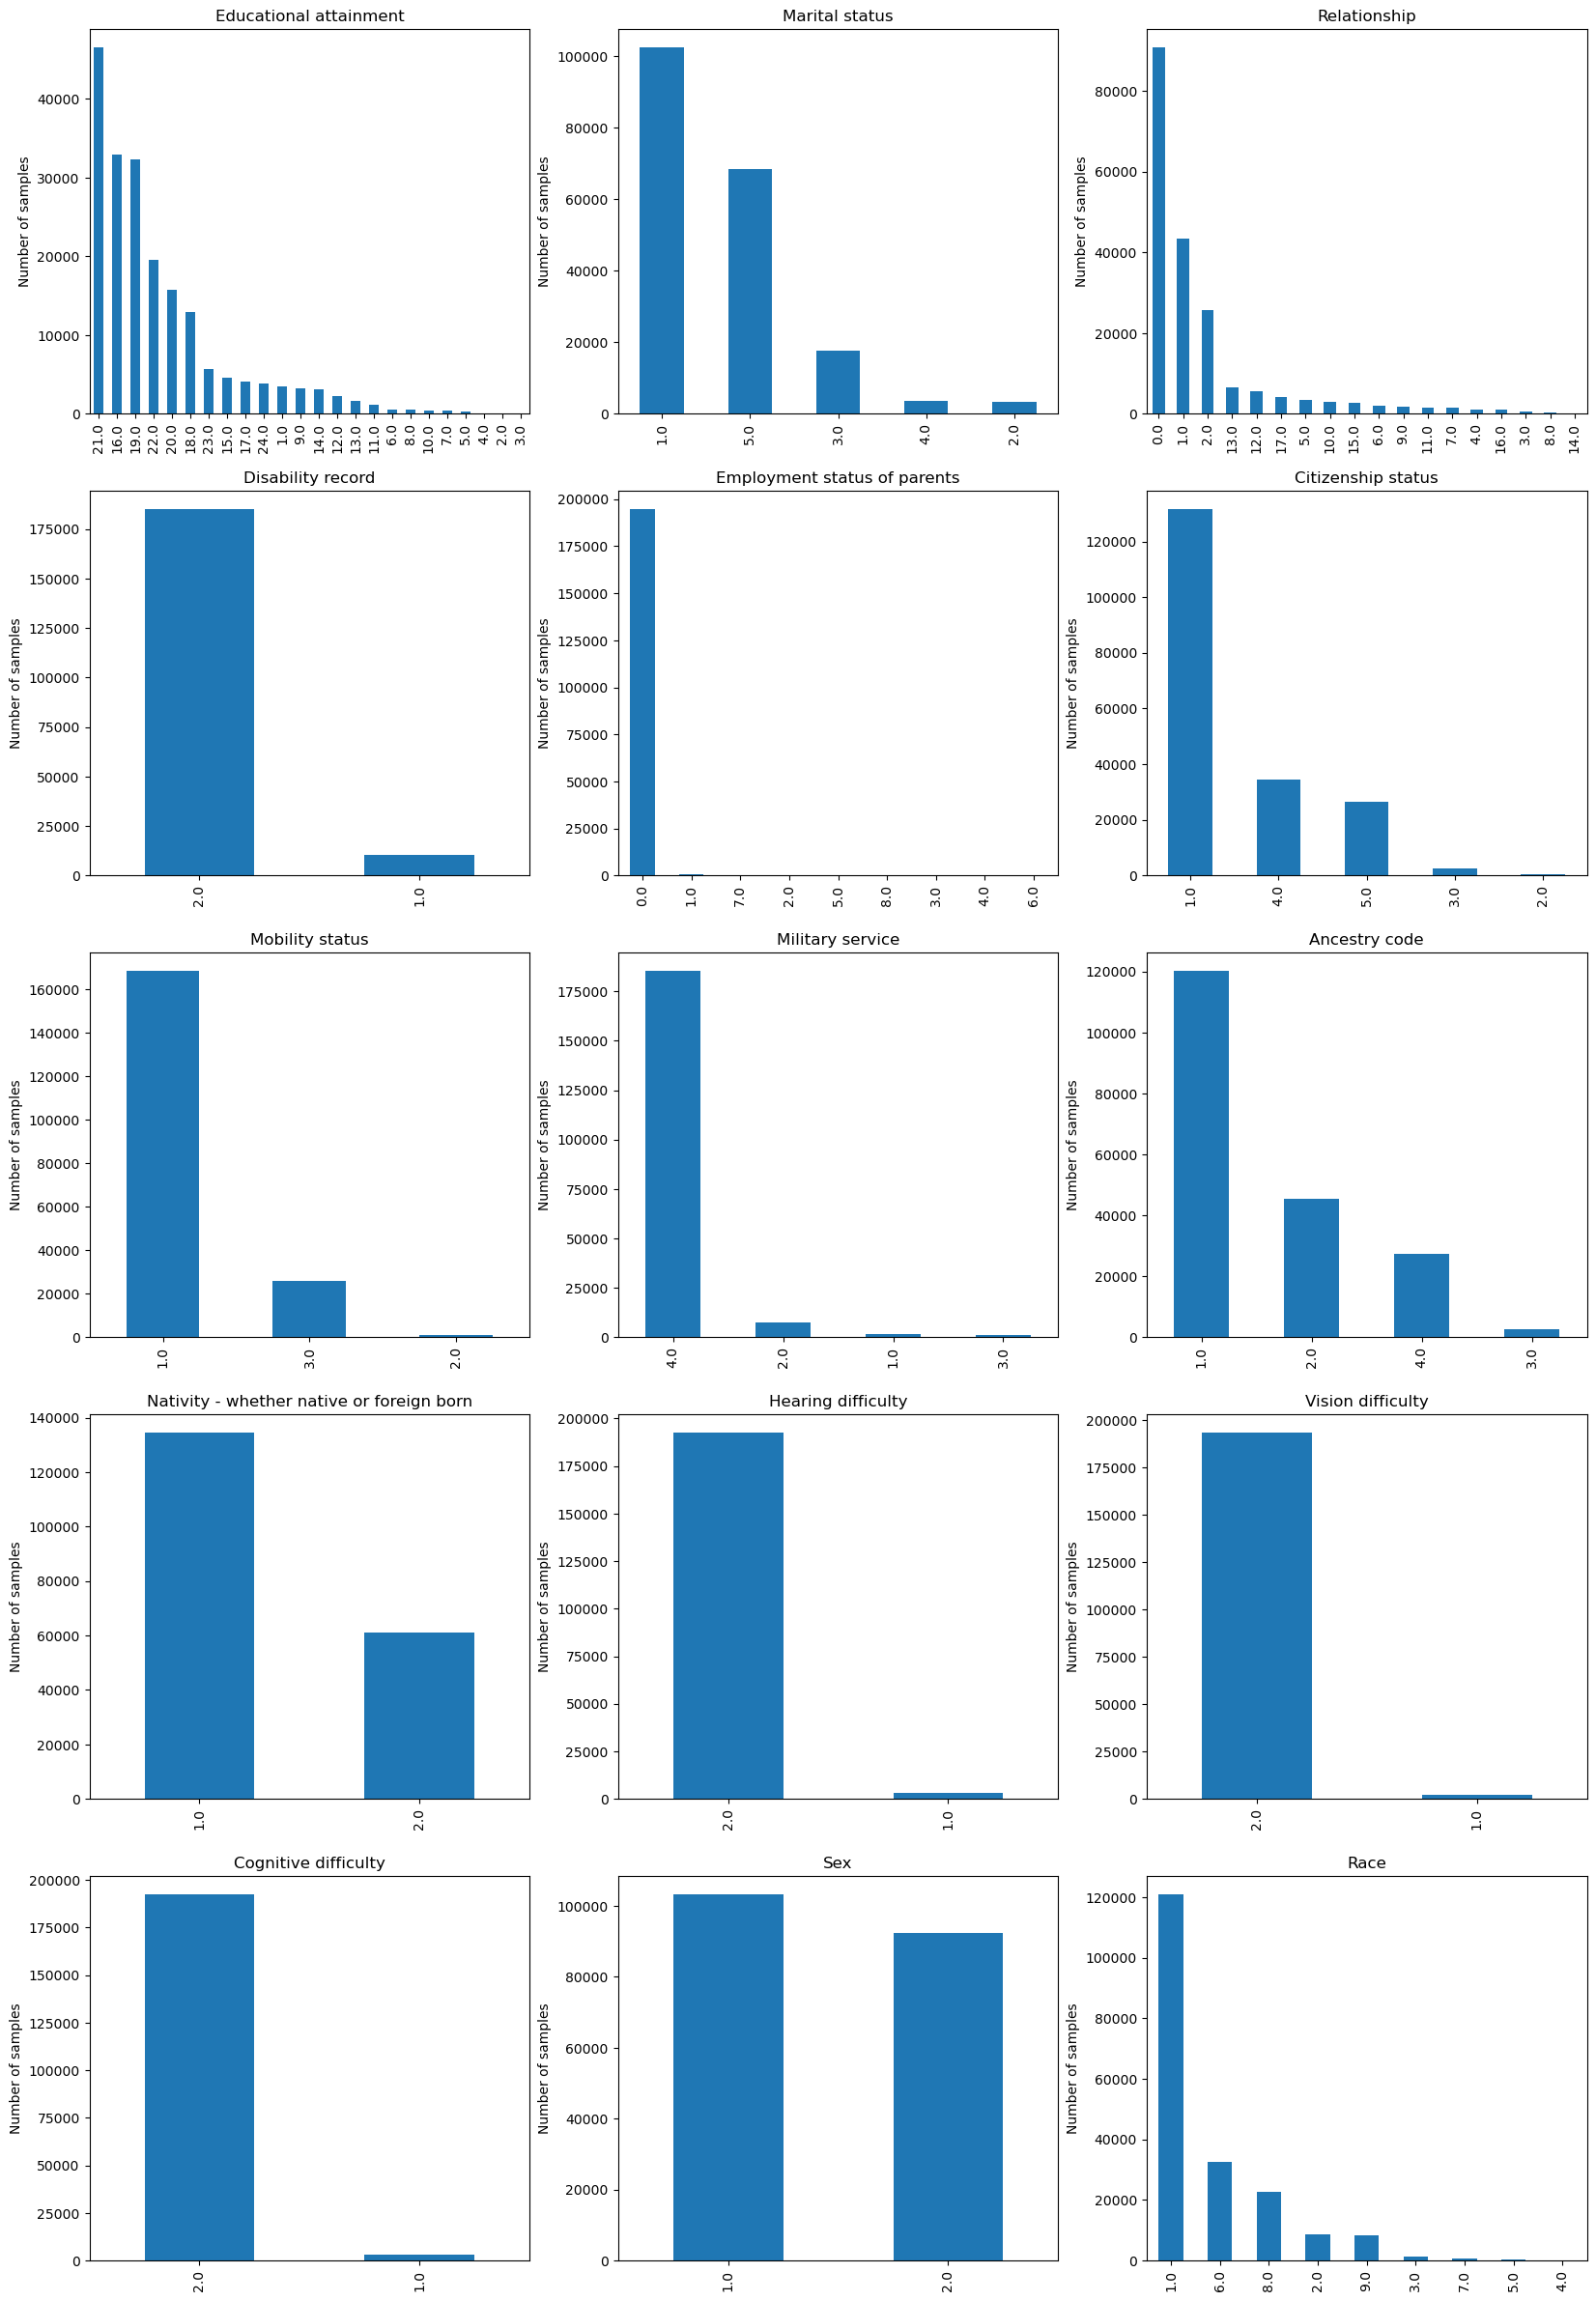

In [45]:
def histograms(data:pd.DataFrame, categorical_features: list[str], column_name_dic: dict) -> (plt.Figure, plt.Axes):
    """
    Creates a histogram plot for each of the categorical features in the given dataframe.

    Args:
        data (pd.DataFrame): dataframe with input features 
        categorical_features (List[str]): list of categorical feature names
    Returns:
        (plt.Figure, plt.Axes): matplotlib figure and axes objects
    """
    
    
    # Add your code here:
    fig, axs = plt.subplots(nrows=round(len(categorical_features)/3), ncols=3, figsize=(20, 30))
    for i, ax in zip(categorical_features, axs.ravel()):
        df[i].value_counts().plot.bar(ax=ax)
        # Set the x-label as title
        ax.set_title(column_name_dic[i])
        ax.set_xlabel('')
        # Set the y-label
        ax.set_ylabel('Number of samples')

    return (fig, ax)

histograms(df, ACSProblem.categorical_features, ACSProblem.column_name_dict)
    

<div class="alert alert-block alert-danger">
<h4>🧑🏼‍💻👩🏿‍💻TASK 2.3: Plotting numerical data</h4>

* Decide an appropriate plot that allows to effectively display the numerical features and the proportion of each target class 
* Create a function `numerical_plot(data:pd.DataFrame, numerical_features: list[str])` that produces the plot you picked
</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
<b>💎 Tip</b>
 
*  Use `ACSProblem.numerical_features` and `ACSProblem.target_task` to get the numerical features and the target task of this ML problem.
</div>


/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


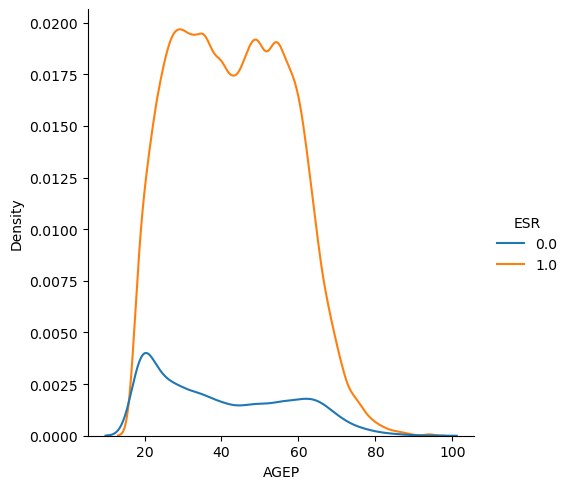

In [46]:
def numerical_plot(data:pd.DataFrame, numerical_features: list[str], target: str):
    """
    Creates a histogram plot for each of the categorical features in the given dataframe.

    Args:
        data (pd.DataFrame): dataframe with input features 
        categorical_features (List[str]): list of categorical feature names
        
    """
       
    # Add your code here:
    # Method 1: Split the age values into 10 bins
    # sns.displot(
    #     df,
    #     x=numerical_features[0],
    #     hue=target,
    #     kind="hist",
    #     stat="count",
    #     bins=10,
    #     multiple="stack"
    # )

    # Method 2: Use the kernel density estimate to plot the age distribution per target class
    # plt.figure(figsize=(15,8))
    
    sns.displot(
    df, x=numerical_features[0], hue=target,
    kind="kde") 
    
numerical_plot(df, ACSProblem.numerical_features, ACSProblem.target_task)

#### 1.3 Data Transformation 

Since we haven't covered data transformations yet, feel free to consider it a black box and not stress about it. However, if you're curious, you can explore the implementation of the `ACSDataset Class`.

In [47]:
# Perform data transformation
df_trans=ACSProblem.data_transforms(df)

/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a fut

In [48]:
# Observe transformed data
df_trans.head()

,AGEP,SCHL_1.0,SCHL_2.0,SCHL_3.0,SCHL_4.0,SCHL_5.0,SCHL_6.0,SCHL_7.0,SCHL_8.0,SCHL_9.0,...,RAC1P_2.0,RAC1P_3.0,RAC1P_4.0,RAC1P_5.0,RAC1P_6.0,RAC1P_7.0,RAC1P_8.0,RAC1P_9.0,RAC1P,ESR
0,0.168831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
1,0.051948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.623377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.207792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.012987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


### 2. Train Baselines and a Classifier (Offline)

Similar to how we've approached the <b>Data Transformation</b> process, we will handle most of the implementation behind the following steps as black-boxes and we will addresss them in later sessions.

<b><span style="color: #C0392B">IMPORTANT NOTE 🛑:</span></b> In ELEC0136 week 7, we will learn that during (offline) model training/fitting phase we usually leverage a training set and a validation set. However, `scikit-learn` library does not have build-in support for validation sets. Therefore, in what follows we use only a training set for the (vanilla) training procedure. See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

#### 2.1 Split data into train/test splits
First,  let's generate the data splits we are going to use for fitting and evaluating our models.

In [49]:
# Generate data splits
train_data, test_data= ACSProblem.generate_splits(df_trans, val_split=False)

# Perform column wise partition for each split
X_train, sens_train, y_train= ACSProblem.columnwise_partition(train_data)
X_test, sens_test, y_test= ACSProblem.columnwise_partition(test_data)

Train data:  (156532, 96)
Test data:  (39133, 96)


#### 2.2 Pick a baseline model
Next, we pick some simple baseline models that we will use as reference points to evaluate whether the developed model is truly learning patterns and performs better than a random or naive approach. We will use the following baselines:

* *Uniformly Random Guess*: Predict the targets with equal probability.
* *Prior Random Guess*: Predict 0 or 1 proportional to the prior probability in the dataset.
* *Majority Class*: Predict only the the majority/most frequent class, i.e., mode (for our example is class 1).

In [50]:
from utils import models

# Develop the baselines
uniform_clf, mode_clf, prior_clf = models.build_baselines(X_train, y_train)

Created uniform classifier!
Created most frequent/mode classifier!
Created prior classifier!


#### 2.3 Pick and train an initial model

Let's select logistic regression as our classifier. You can experiment with other models (e.g. an MLP) at a later time.

In [51]:
# Develop the logistic regression model
LR_clf=models.build_LRModel(X_train, y_train)

/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anlly/anaconda3/envs/daps/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

Trained logistic regression!


### 3. Evaluate and Audit for Fairness the Baselines and the Classifier

In what follows we evaluate the performance of the produced baselines and naive model using the following metris:
1. Accuracy: measures correct perdictions
2. Precision: accuracy of positive predictions
3. Recall: measures the ability to correctly identify positive instances
4. F1-score: provides a balance between precision and recall, especially when there is an uneven class distribution
5. Confusion Matrix:summary of the model's predictions versus the actual classes and includes four metrics: true positive, true negative, false positive, and false negative.
6. Demographic Parity Difference: measures the disparity in positive outcomes among sensitive groups.
7. Equality of Odds Difference: measures the disparity in true positive and false positive rates across sensitive groups.
</div>

In [52]:
# Libraries for resutls reporting
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score, f1_score,ConfusionMatrixDisplay
from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference

def report_performance(model_list: list[str], X:pd.DataFrame, y:pd.DataFrame, sens:pd.DataFrame):
    # Add your code here:

    for model in model_list:
        y_pred=model.predict(X)
        print('-----------------')
        print(f"Performance of {model}")
        print("Accuracy:", accuracy_score(y, y_pred))
        print("Precision:", precision_score(y, y_pred))
        print("Recall:", recall_score(y, y_pred))
        print("F1-score:", f1_score(y, y_pred))
        print("Confusion Matrix:", confusion_matrix(y, y_pred))
        print("Demographic Parity Difference:", demographic_parity_difference(
        y, y_pred, sensitive_features=sens))
        print("Equalized Odds Difference:", equalized_odds_difference(
        y, y_pred, sensitive_features=sens)
    )


In [53]:
#  Examine performance on training set
from warnings import simplefilter
simplefilter(action="ignore",category=FutureWarning)
report_performance([uniform_clf, mode_clf, prior_clf,LR_clf],X_train,y_train,sens_train)


-----------------
Performance of DummyClassifier(random_state=0, strategy='uniform')
Accuracy: 0.5013990749495311


Precision: 0.8813105558388578
Recall: 0.5014252866893455
F1-score: 0.6391841225665373
Confusion Matrix: [[ 9355  9310]
 [68737 69130]]
Demographic Parity Difference: 0.06953386556785995
Equalized Odds Difference: 0.10785241248817407
-----------------
Performance of DummyClassifier(random_state=0, strategy='most_frequent')
Accuracy: 0.8807592057853985
Precision: 0.8807592057853985
Recall: 1.0
F1-score: 0.9365996487759809
Confusion Matrix: [[     0  18665]
 [     0 137867]]
Demographic Parity Difference: 0.0
Equalized Odds Difference: 0.0
-----------------
Performance of DummyClassifier(random_state=0)
Accuracy: 0.8807592057853985
Precision: 0.8807592057853985
Recall: 1.0
F1-score: 0.9365996487759809
Confusion Matrix: [[     0  18665]
 [     0 137867]]
Demographic Parity Difference: 0.0
Equalized Odds Difference: 0.0
-----------------
Performance of LogisticRegression(max_iter=2500, penalty='none')
Accuracy: 0.894385812485626
Precision: 0.8954985494963982
Recall: 0.9963588095773462
F1-sc

In [54]:
#  Examine performance on test set
report_performance([uniform_clf, mode_clf, prior_clf,LR_clf],X_test,y_test,sens_test)

-----------------
Performance of DummyClassifier(random_state=0, strategy='uniform')
Accuracy: 0.5000638847008918
Precision: 0.8786610878661087
Recall: 0.5004940998663024
F1-score: 0.6377305384786313
Confusion Matrix: [[ 2349  2378]
 [17186 17220]]
Demographic Parity Difference: 0.0620705993840322
Equalized Odds Difference: 0.7333333333333333
-----------------
Performance of DummyClassifier(random_state=0, strategy='most_frequent')
Accuracy: 0.879206807553727
Precision: 0.879206807553727
Recall: 1.0
F1-score: 0.9357211819578728
Confusion Matrix: [[    0  4727]
 [    0 34406]]
Demographic Parity Difference: 0.0
Equalized Odds Difference: 1.0
-----------------
Performance of DummyClassifier(random_state=0)
Accuracy: 0.879206807553727
Precision: 0.879206807553727
Recall: 1.0
F1-score: 0.9357211819578728
Confusion Matrix: [[    0  4727]
 [    0 34406]]
Demographic Parity Difference: 0.0
Equalized Odds Difference: 1.0
-----------------
Performance of LogisticRegression(max_iter=2500, penalt

<div class="alert alert-block alert-danger">
<b> Q: What insights can you derive from the reported metrics for all models? </b>
</div>

In [55]:
# Add your response here:
# We notice that the Demographic Parity difference across all model is very low, indicating that all gorups have similar selection rate. 

# In contrast Equalized Odds difference is very high across all models except the classifier that performs uniformly random guesses. 
# This suggests that there are significant disparities in predictive performance among different groups and randomly predicting the 
# employment of an individual is more fair (wrt Equilized Odds) than using the logistic regression classifier.

### 4. Postprocessing Techniques for Fairness


Since we audited the (naive/initial) logistic regression model for fairness and we noticed that it does not satisfy Equalizes Odds, we are going to enforce this fairness metric as a postprocessing technique. 

To do so, we are going to use `fairlearn` library's [`ThresholdOptimzer`](https://fairlearn.org/v0.9/api_reference/generated/fairlearn.postprocessing.ThresholdOptimizer.html?highlight=thresholdoptimizer#fairlearn.postprocessing.ThresholdOptimizer) to implement Equality of Opportunity. 


You can find the original paper introducing Equalized Odds [here](https://proceedings.neurips.cc/paper/2016/file/9d2682367c3935defcb1f9e247a97c0d-Paper.pdf).

In [56]:
from fairlearn.postprocessing import ThresholdOptimizer

def build_EOddFairModel(cls,  X:pd.DataFrame, y:pd.DataFrame, sens:pd.DataFrame):
    # Set up ThresholdOptimizer
    eo_model = ThresholdOptimizer(
        estimator=cls,
        constraints="equalized_odds", # Optimize FPR and FNR simultaneously
        objective="balanced_accuracy_score", # accuracy_score
        grid_size=1000,
        flip=False,
        prefit=False,
        predict_method="predict_proba",
    )
    
    # Adjust the results that the classifier would produce by letting ThresholdOptimizer know what the sensitive features are
    eo_model.fit(X, y, sensitive_features=sens)

    return eo_model

# Postprocess the trained classifier to satisfy Equalized Odds
eoFair_clf= build_EOddFairModel(LR_clf,X_train, y_train, sens_train)

In [57]:
# Examine EO-fair classifier on train data
y_train_eo= eoFair_clf.predict(
    X_train, sensitive_features=sens_train
)
# Examine EO-fair classifier on test data
y_test_eo= eoFair_clf.predict(
    X_test, sensitive_features=sens_test
)

In [58]:
#  Print again report on test set for the previous models
report_performance([uniform_clf, mode_clf, prior_clf,LR_clf],X_test,y_test,sens_test)

-----------------
Performance of DummyClassifier(random_state=0, strategy='uniform')
Accuracy: 0.5000638847008918
Precision: 0.8786610878661087
Recall: 0.5004940998663024
F1-score: 0.6377305384786313
Confusion Matrix: [[ 2349  2378]
 [17186 17220]]
Demographic Parity Difference: 0.0620705993840322
Equalized Odds Difference: 0.7333333333333333
-----------------
Performance of DummyClassifier(random_state=0, strategy='most_frequent')
Accuracy: 0.879206807553727
Precision: 0.879206807553727
Recall: 1.0
F1-score: 0.9357211819578728
Confusion Matrix: [[    0  4727]
 [    0 34406]]
Demographic Parity Difference: 0.0
Equalized Odds Difference: 1.0
-----------------
Performance of DummyClassifier(random_state=0)
Accuracy: 0.879206807553727
Precision: 0.879206807553727
Recall: 1.0
F1-score: 0.9357211819578728
Confusion Matrix: [[    0  4727]
 [    0 34406]]
Demographic Parity Difference: 0.0
Equalized Odds Difference: 1.0
-----------------
Performance of LogisticRegression(max_iter=2500, penalt

In [59]:
#  Print report for this EO-fair classifier

print('-----------------')
print("Accuracy:", accuracy_score(y_test, y_test_eo))
print("Precision:", precision_score(y_test, y_test_eo))
print("Recall:", recall_score(y_test, y_test_eo))
print("F1-score:", f1_score(y_test, y_test_eo))
print("Confusion Matrix:", confusion_matrix(y_test, y_test_eo))
print("Demographic Parity Difference:", demographic_parity_difference(y_test, y_test_eo, sensitive_features=sens_test))
print("Equalized Odds Difference:", equalized_odds_difference(
    y_test, y_test_eo, sensitive_features=sens_test))

-----------------
Accuracy: 0.7764291007589502
Precision: 0.9099741139624812
Recall: 0.827588211358484
F1-score: 0.8668280134557133
Confusion Matrix: [[ 1910  2817]
 [ 5932 28474]]
Demographic Parity Difference: 0.21703617269544928
Equalized Odds Difference: 0.7333333333333333


Text(0.5, 1.0, 'EO trained LR')

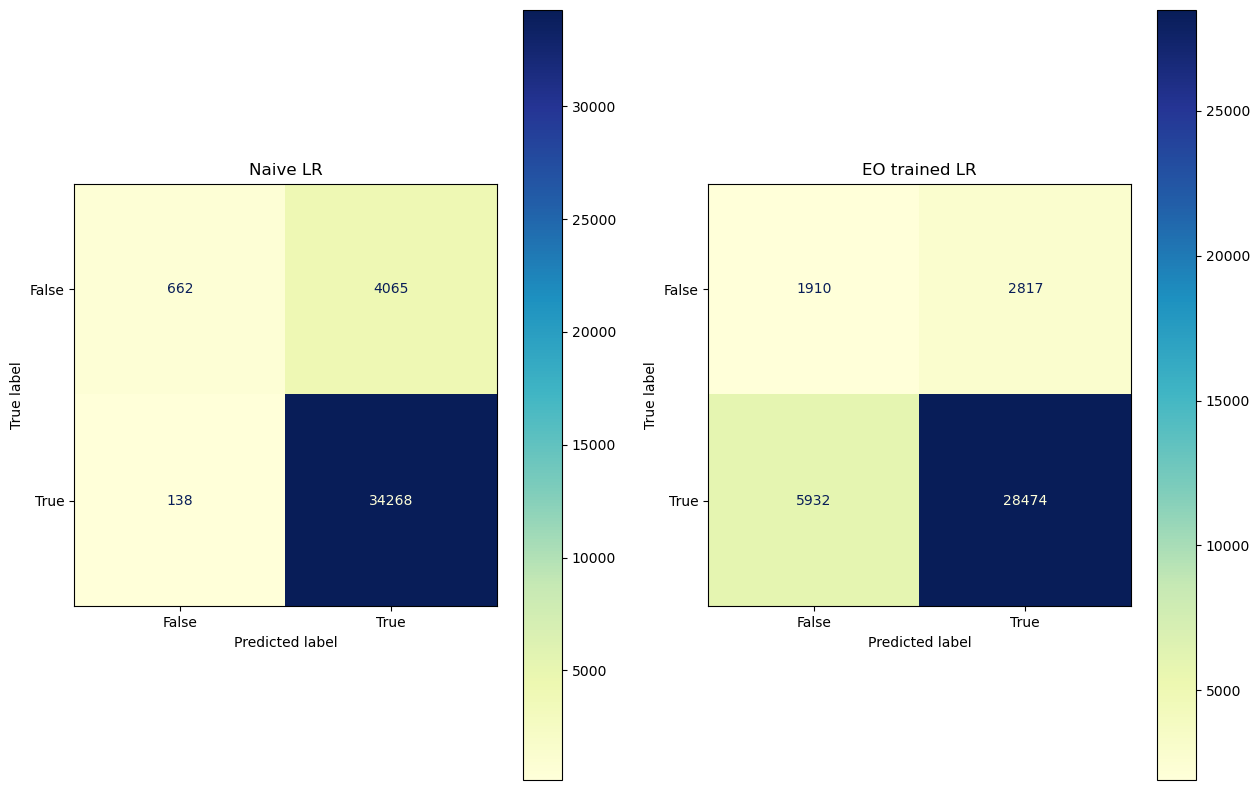

In [60]:
# Plot confusion matrices for the EO-fair and initial/naive classifiers 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, LR_clf.predict(X_test)), 
    display_labels=[False, True]).plot(ax=ax[0],cmap=plt.cm.YlGnBu)
ax[0].set_title("Naive LR")

ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_test_eo), 
    display_labels=[False, True],).plot(ax=ax[1],cmap=plt.cm.YlGnBu)
ax[1].set_title("EO trained LR") 


#### Pick a dataset and upload it on [Aequitas](http://aequitas.dssg.io/) to generate a bias report!!